In [3]:
from sqlalchemy import create_engine 
import pandas as pd

DB_USER='postgres'
DB_password='1234'
DB_host='127.0.0.1'
DB_port='5432'
DB_name='postgres'

In [4]:
connection_string = f'postgresql://{DB_USER}:{DB_password}@{DB_host}:{DB_port}/{DB_name}'


In [5]:
engine=create_engine(connection_string)

In [6]:
def run_query(query,engine):
    try:   
        result=pd.read_sql_query(query,engine)
        return result
    except Exception as e:
         print('error message query :{query}')
         print(str(e))
         return none 
    

In [7]:
query='select * from sales_fact'
result= run_query(query,engine)
if result is not None:
    print(result)

     surrogate_key   date_id  junk_id  order_id       date   total  quantity  \
0               28  20190310       28       993  3/10/2019  184.11         2   
1               29  20190125       29       991  1/25/2019  463.89         5   
2               30  20190315       30       983  3/15/2019  235.21         9   
3               31  20190225       31       991  2/25/2019  494.18         5   
4               32  20190128       32       983  1/28/2019  737.76         9   
..             ...       ...      ...       ...        ...     ...       ...   
995            956  20190106      956      1000   1/6/2019  312.89         7   
996            957  20190110      957       983  1/10/2019  477.13         9   
997            958  20190207      958       978   2/7/2019  289.93         6   
998            959  20190109      959       997   1/9/2019  165.90        10   
999            960  20190219      960       983  2/19/2019  932.34         9   

     unit_price  gross_income  
0      

In [8]:
query='select * from order_dim'
data= run_query(query,engine)
if data is not None:
    print(data)

     order_id   invoice_id            product_line  unit_price  quantity  \
0           1  750-67-8428       Health and beauty        74.0         7   
1           2  226-31-3081  Electronic accessories        15.0         5   
2           3  631-41-3108      Home and lifestyle        46.0         7   
3           4  123-19-1176       Health and beauty        58.0         8   
4           5  373-73-7910       Sports and travel        86.0         7   
..        ...          ...                     ...         ...       ...   
995       996  233-67-5758       Health and beauty        40.0         1   
996       997  303-96-2227      Home and lifestyle        97.0        10   
997       998  727-02-1313      Food and beverages        31.0         1   
998       999  347-56-2442      Home and lifestyle        65.0         1   
999      1000  849-09-3807     Fashion accessories        88.0         7   

    payment_method  rating  
0          Ewallet       9  
1             Cash       9  


In [9]:
query='select * from junk_dim'
junk= run_query(query,engine)
if junk is not None:
    print(junk)

     junk_id customer_sex branch customer_type  gross_income
0          1       Female   A           Member         26.14
1          2       Female   C           Normal          3.82
2          3         Male   A           Normal         16.22
3          4         Male   A           Member         23.29
4          5         Male   A           Normal         30.21
..       ...          ...    ...           ...           ...
995      996         Male   C           Normal          2.02
996      997       Female   B           Normal         48.69
997      998         Male   A           Member          1.59
998      999         Male   A           Normal          3.29
999     1000       Female   A           Member         30.92

[1000 rows x 5 columns]


In [10]:
query='select * from date_dim'
Date= run_query(query,engine)
if Date is not None:
    print(Date)

     date_id        date  year  month  day  is_holiday month_name   day_name  \
0   20190101  2019-01-01  2019      1    1       False  January    Tuesday     
1   20190102  2019-01-02  2019      1    2       False  January    Wednesday   
2   20190103  2019-01-03  2019      1    3       False  January    Thursday    
3   20190104  2019-01-04  2019      1    4       False  January    Friday      
4   20190105  2019-01-05  2019      1    5        True  January    Saturday    
..       ...         ...   ...    ...  ...         ...        ...        ...   
85  20190327  2019-03-27  2019      3   27       False  March      Wednesday   
86  20190328  2019-03-28  2019      3   28       False  March      Thursday    
87  20190329  2019-03-29  2019      3   29       False  March      Friday      
88  20190330  2019-03-30  2019      3   30        True  March      Saturday    
89  20190331  2019-03-31  2019      3   31        True  March      Sunday      

    quarter  
0         1  
1         1

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime


In [12]:
# SQL Queries for analysis
queries = {
    "date_range": 
        """
        SELECT MIN(date) AS start_date, MAX(date) AS end_date, 
               COUNT(DISTINCT date) AS unique_invoice_days
        FROM date_dim;
        """,
    "profit_by_day": 
        """
        SELECT dd.date, SUM(sf.gross_income) AS total_gross_income
        FROM sales_fact sf
        JOIN date_dim dd ON sf.date_id = dd.date_id
        GROUP BY dd.date
        ORDER BY total_gross_income;
        """,
    "branch_analysis": 
        """
        SELECT jd.branch, COUNT(DISTINCT sf.order_id) AS invoice_count,
               SUM(sf.gross_income) AS total_gross_income
        FROM sales_fact sf
        JOIN junk_dim jd ON sf.junk_id = jd.junk_id
        GROUP BY jd.branch
        ORDER BY total_gross_income DESC;
        """,
    "customer_payment": 
        """
        SELECT jd.customer_type, COUNT(*) AS count
        FROM junk_dim jd
        GROUP BY jd.customer_type
        UNION ALL
        SELECT od.payment_method, COUNT(*) AS count
        FROM order_dim od
        GROUP BY od.payment_method;
        """,
    "product_rating": 
        """
        SELECT od.product_line, COUNT(*) AS count, AVG(od.rating) AS avg_rating
        FROM order_dim od
        GROUP BY od.product_line
        ORDER BY count DESC;
        """,
    "gender_quantity": 
        """
        SELECT jd.customer_sex AS gender, SUM(sf.quantity) AS total_quantity
        FROM sales_fact sf
        JOIN junk_dim jd ON sf.junk_id = jd.junk_id
        GROUP BY jd.customer_sex;
        """,
    "product_gender":
        """
        SELECT od.product_line, jd.customer_sex AS gender, 
               SUM(sf.quantity) AS total_quantity
        FROM sales_fact sf
        JOIN order_dim od ON sf.order_id = od.order_id
        JOIN junk_dim jd ON sf.junk_id = jd.junk_id
        GROUP BY od.product_line, jd.customer_sex
        ORDER BY od.product_line, total_quantity DESC;
        """,
    "sales_trend": 
        """
        SELECT dd.date, SUM(sf.Total) AS daily_sales
        FROM sales_fact sf
        JOIN date_dim dd ON sf.date_id = dd.date_id
        GROUP BY dd.date
        ORDER BY dd.date;
        """,
    "revenue_product": 
        """
        SELECT od.product_line, SUM(sf.Total) AS total_revenue
        FROM sales_fact sf
        JOIN order_dim od ON sf.order_id = od.order_id
        GROUP BY od.product_line
        ORDER BY total_revenue DESC;
        """
}

# Example query execution
for query_name, query in queries.items():
    result = run_query(query, engine)
    if result is not None:
        print(f"\nResults for {query_name}:")
        print(result)


Results for date_range:
   start_date    end_date  unique_invoice_days
0  2019-01-01  2019-03-31                   90

Results for profit_by_day:
          date  total_gross_income
0   2019-02-13               44.50
1   2019-03-18               61.56
2   2019-02-21               66.38
3   2019-03-07               68.49
4   2019-02-18               71.24
..         ...                 ...
84  2019-03-02              312.39
85  2019-02-15              325.27
86  2019-03-14              343.55
87  2019-02-07              344.19
88  2019-03-09              355.90

[89 rows x 2 columns]

Results for branch_analysis:
  branch  invoice_count  total_gross_income
0   C                10             5278.54
1   A                10             5051.95
2   B                10             5048.99

Results for customer_payment:
  customer_type  count
0        Normal    499
1        Member    501
2   Credit card    311
3       Ewallet    345
4          Cash    344

Results for product_rating:
      

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from datetime import datetime

In [14]:
def run_query(engine, query):
    return pd.read_sql_query(query, engine)

In [15]:
def date_range_analysis(df):
    print("Date Range Analysis:")
    print(f"Start Date: {df['start_date'].iloc[0]}")
    print(f"End Date: {df['end_date'].iloc[0]}")
    print(f"Number of unique invoice days: {df['unique_invoice_days'].iloc[0]}")

def profit_analysis(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['total_gross_income'])
    plt.title('Daily Gross Income')
    plt.xlabel('Date')
    plt.ylabel('Gross Income')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def branch_analysis(df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='branch', y='total_gross_income', data=df)
    plt.title('Total Gross Income by Branch')
    plt.xlabel('Branch')
    plt.ylabel('Total Gross Income')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(x='branch', y='invoice_count', data=df)
    plt.title('Invoice Count by Branch')
    plt.xlabel('Branch')
    plt.ylabel('Invoice Count')
    plt.show()

def customer_payment_analysis(df):
    customer_types = df[df['customer_type'].isin(['Member', 'Normal'])]
    payment_methods = df[~df['customer_type'].isin(['Member', 'Normal'])]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.barplot(x='customer_type', y='count', data=customer_types, ax=ax1)
    ax1.set_title('Customer Type Distribution')
    ax1.set_xlabel('Customer Type')
    ax1.set_ylabel('Count')

    sns.barplot(x='customer_type', y='count', data=payment_methods, ax=ax2)
    ax2.set_title('Payment Method Distribution')
    ax2.set_xlabel('Payment Method')
    ax2.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

def product_rating_analysis(df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='product_line', y='count', data=df)
    plt.title('Product Line Distribution')
    plt.xlabel('Product Line')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(x='product_line', y='avg_rating', data=df)
    plt.title('Average Rating by Product Line')
    plt.xlabel('Product Line')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=45)
    plt.show()

def gender_quantity_analysis(df):
    plt.figure(figsize=(8, 6))
    sns.barplot(x='gender', y='total_quantity', data=df)
    plt.title('Total Quantity Purchased by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Total Quantity')
    plt.show()

def product_gender_analysis(df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='product_line', y='total_quantity', hue='gender', data=df)
    plt.title('Product Line Purchases by Gender')
    plt.xlabel('Product Line')
    plt.ylabel('Total Quantity')
    plt.xticks(rotation=45)
    plt.legend(title='Gender')
    plt.show()

def sales_trend_analysis(df):
    df['date'] = pd.to_datetime(df['date'])
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['daily_sales'])
    plt.title('Sales Trend Over Time')
    plt.xlabel('Date')
    plt.ylabel('Daily Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def revenue_product_analysis(df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='product_line', y='total_revenue', data=df)
    plt.title('Total Revenue by Product Line')
    plt.xlabel('Product Line')
    plt.ylabel('Total Revenue')
    plt.xticks(rotation=45)
    plt.show()

Date Range Analysis:
Start Date: 2019-01-01
End Date: 2019-03-31
Number of unique invoice days: 90


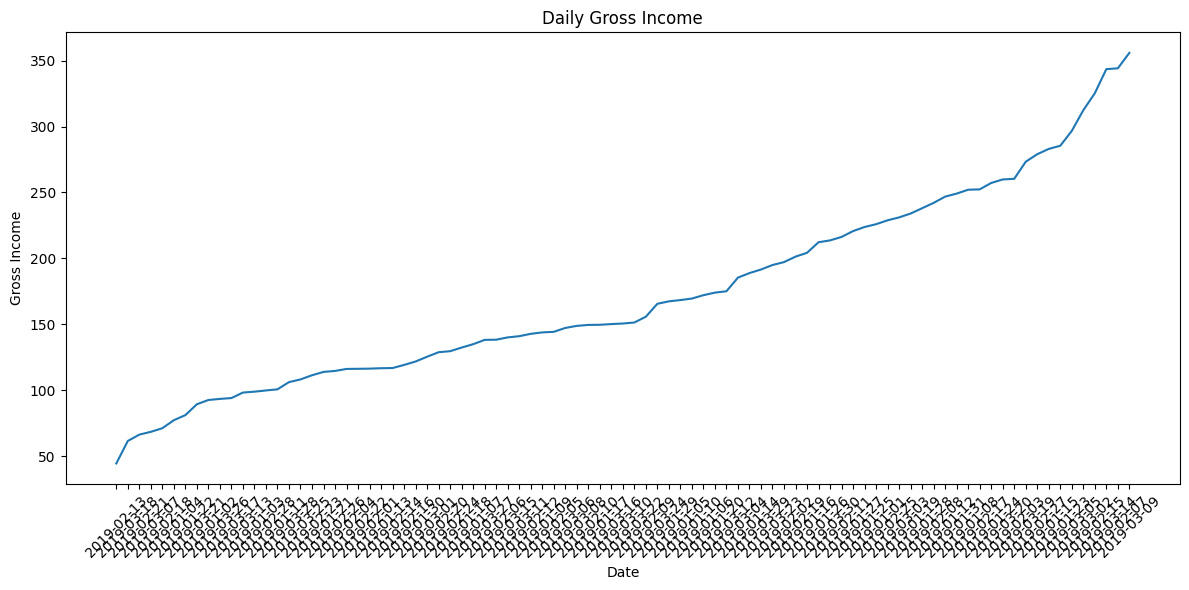

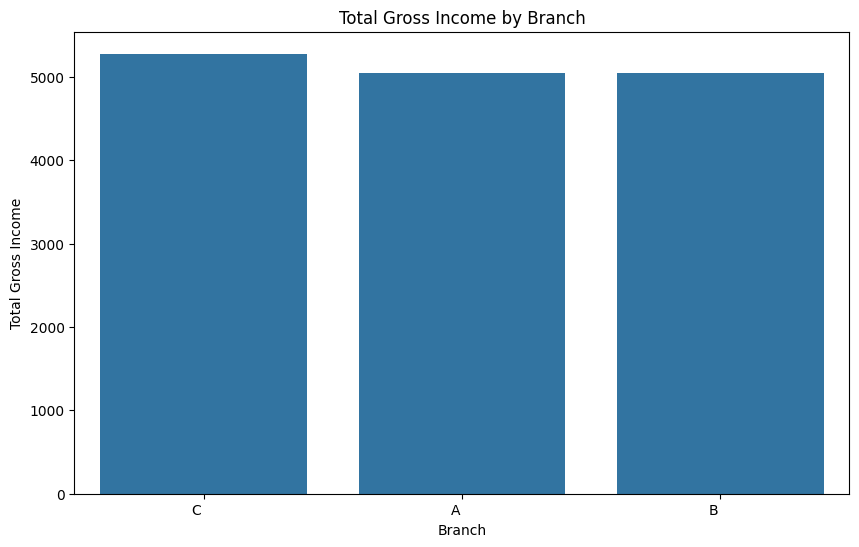

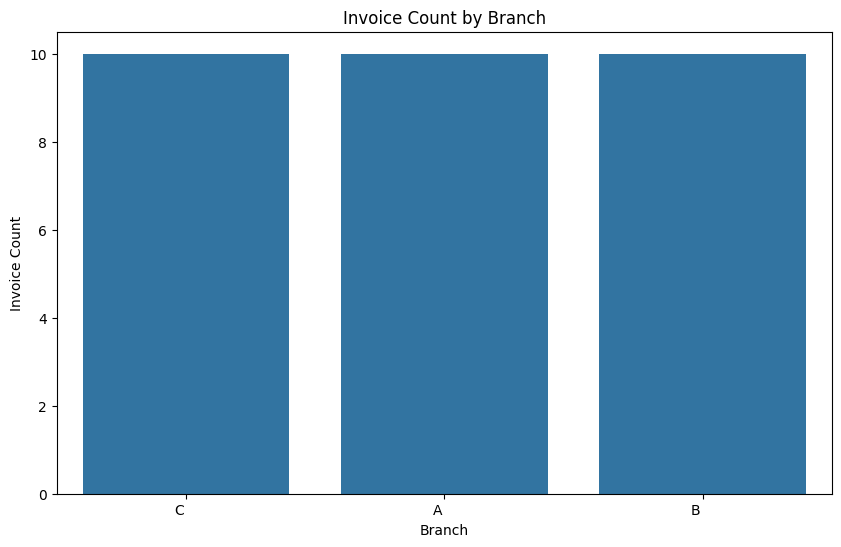

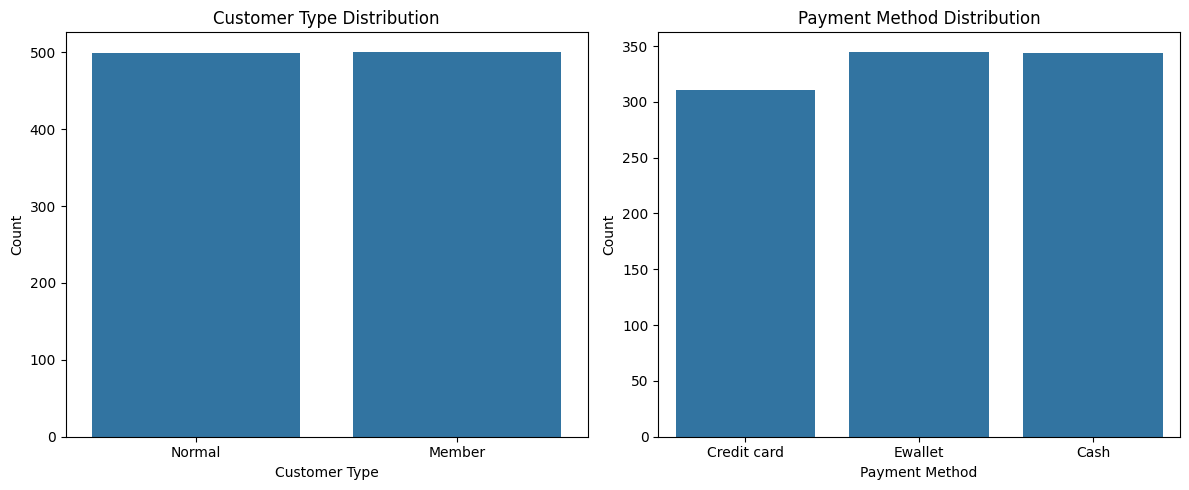

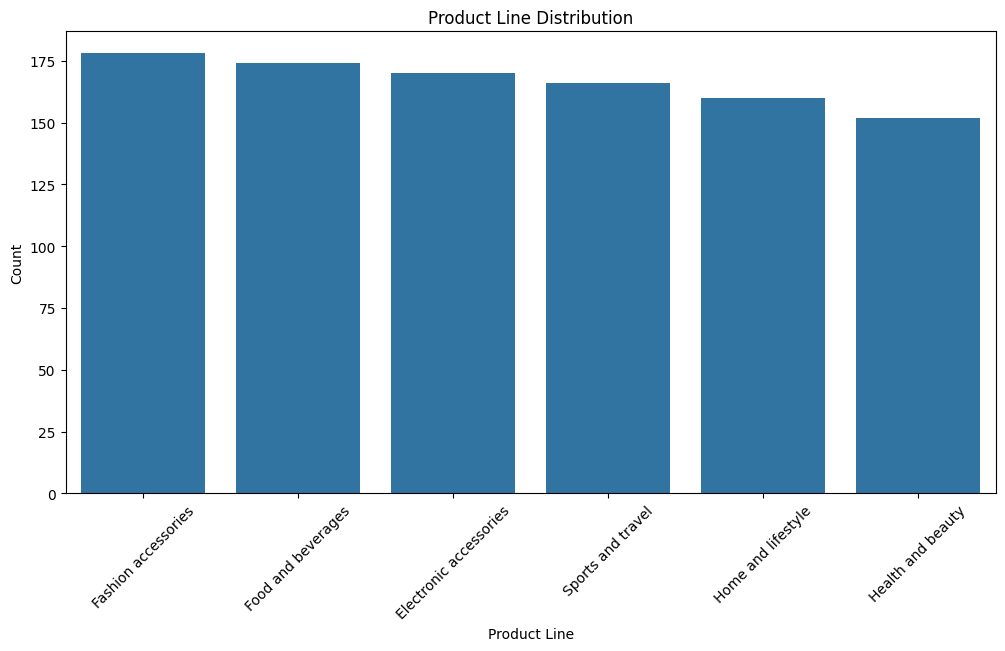

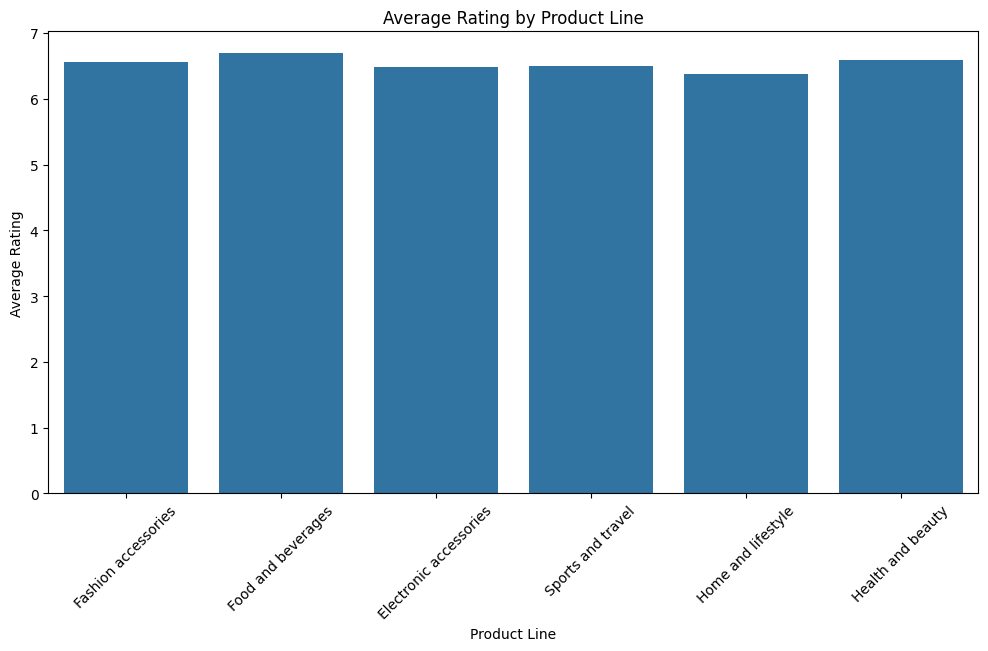

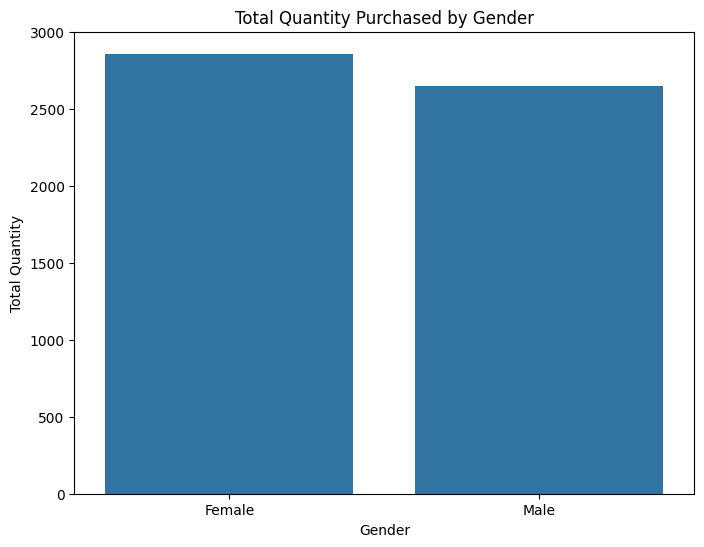

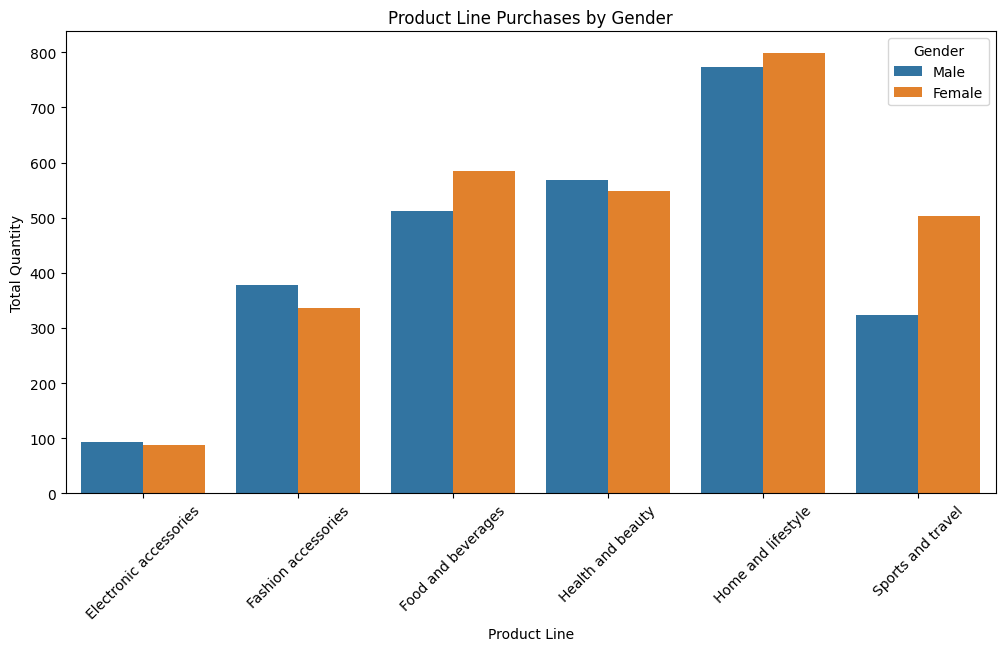

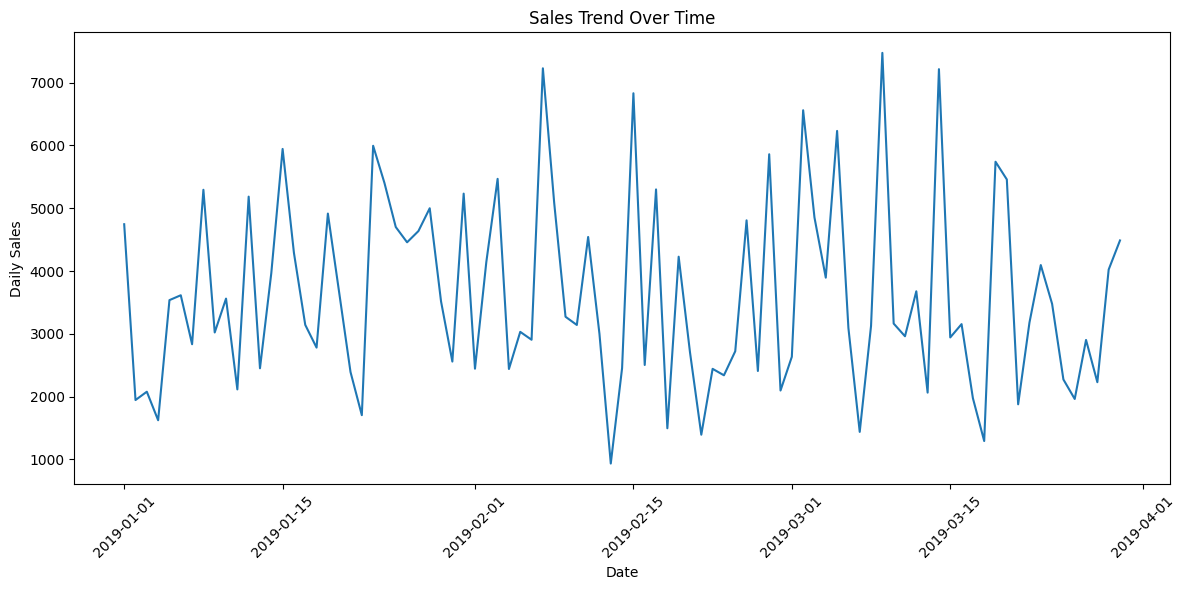

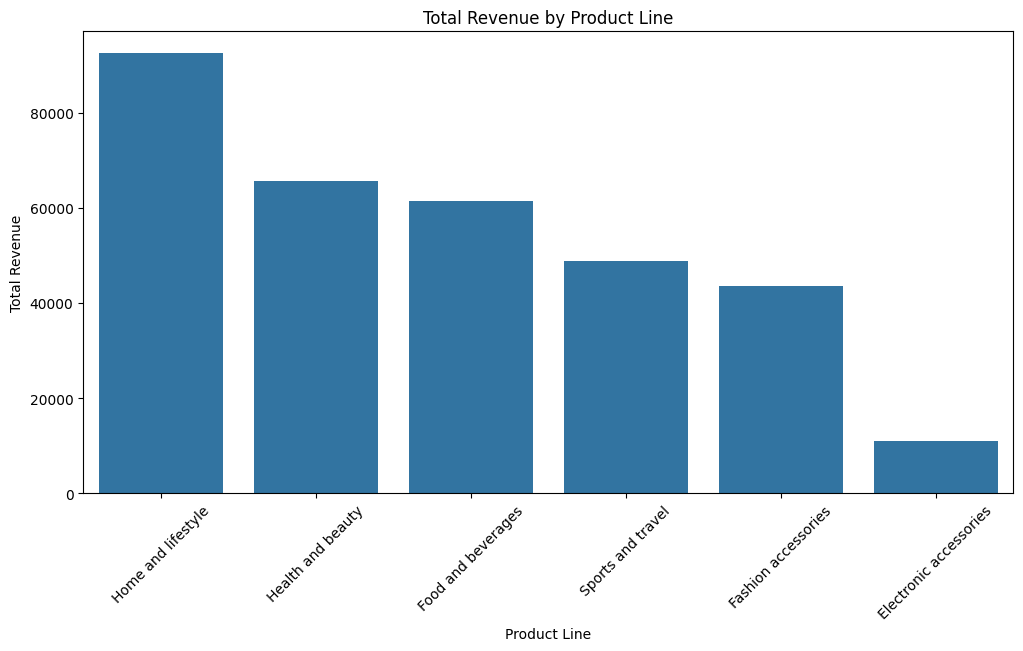

In [16]:

    
    # Run analyses
    date_range_analysis(run_query(engine, queries['date_range']))
    profit_analysis(run_query(engine, queries['profit_by_day']))
    branch_analysis(run_query(engine, queries['branch_analysis']))
    customer_payment_analysis(run_query(engine, queries['customer_payment']))
    product_rating_analysis(run_query(engine, queries['product_rating']))
    gender_quantity_analysis(run_query(engine, queries['gender_quantity']))
    product_gender_analysis(run_query(engine, queries['product_gender']))
    sales_trend_analysis(run_query(engine, queries['sales_trend']))
    revenue_product_analysis(run_query(engine, queries['revenue_product']))
